# Projeto Final: Pipeline ETL com PokeAPI

Este notebook implementa um pipeline ETL (Extract, Transform, Load) utilizando a PokeAPI. O objetivo é extrair dados sobre Pokémons, transformar esses dados para um formato adequado e carregá-los em um banco de dados para análises futuras.

## Objetivos do Pipeline ETL
- **Extração:** Obter dados da PokeAPI
- **Transformação:** Limpar e transformar os dados extraídos
- **Carregamento:** Inserir os dados transformados em um banco de dados
- **Alertas:** Implementar mecanismos de alerta para falhas no processo ETL
- **Análise:** Levantar hipóteses e plotar gráficos que as confirmem (ou não)

### 1. Importação das bibliotecas necessárias

In [1]:
import requests
import pandas as pd
import numpy as np
import sqlite3
from plyer import notification
from datetime import datetime
import os

### 2. Função de criação do alerta

In [2]:
def enviar_alerta(nivel, base, etapa):
    """
    Envia uma notificação de alerta.

    Parâmetros:
    nivel (int): Nível do alerta (1=Baixo, 2=Médio, 3=Alto).
    base (str): Base de dados envolvida.
    etapa (str): Etapa do processo onde ocorreu o erro.

    Retorna:
    None
    """
    alertas = {1: 'Baixo', 2: 'Médio', 3: 'Alto'}
    alerta = alertas.get(nivel, 'Desconhecido')
    titulo = f"Alerta {alerta}"
    mensagem = f"Falha no carregamento da base {base} na etapa {etapa} \n{datetime.now()}"
    notification.notify(
        title=titulo,
        message=mensagem,
        app_name="etl_pipeline",
        timeout=10
    )

### 3. Obtendo dados da API

In [3]:
def obter_dados_da_api(url):
    """
    Faz uma requisição GET para a API e retorna os dados em JSON.

    Parâmetros:
    url (str): URL da API.

    Retorna:
    dict: Dados em JSON da API, ou None em caso de erro.
    """
    resposta = requests.get(url)
    if resposta.status_code == 200:
        return resposta.json()
    else:
        enviar_alerta(3, url, "Extração")
        print(f"ERRO: Falha ao buscar dados da API. Código de status: {resposta.status_code}")
        return None

### 4. Extração todas as páginas de uma API paginada

In [4]:
def extrair_todas_paginas(base_url):
    """
    Extrai dados de todas as páginas de uma API paginada.

    Parâmetros:
    base_url (str): URL base da API.

    Retorna:
    list: Lista de resultados combinados de todas as páginas.
    """
    resultados = []
    url = base_url
    while url:
        dados = obter_dados_da_api(url)
        if dados:
            resultados.extend(dados['results'])
            url = dados.get('next')
        else:
            break
    return resultados

### 5. Extração dos dados de pokemons

In [5]:
def extrair_pokemons(limite=50):
    """
    Extrai dados de Pokémon da API.

    Parâmetros:
    limite (int): Número de Pokémon a serem extraídos.

    Retorna:
    DataFrame: Dados dos Pokémon transformados em um DataFrame.
    """
    url = f'https://pokeapi.co/api/v2/pokemon?limit={limite}'
    dados = obter_dados_da_api(url)
    if not dados:
        return pd.DataFrame()  # Retorna um DataFrame vazio em caso de erro

    pokemons = []
    for item in dados['results']:
        dados_pokemon = obter_dados_da_api(item['url'])
        if dados_pokemon:
            habilidades = [int(habilidade['ability']['url'].split('/')[-2]) for habilidade in dados_pokemon['abilities']]
            tipos = [int(tipo['type']['url'].split('/')[-2]) for tipo in dados_pokemon['types']]
            pokemons.append({
                'id': dados_pokemon['id'],
                'nome': dados_pokemon['name'],
                'experiencia_base': dados_pokemon['base_experience'],
                'altura': dados_pokemon['height'],
                'peso': dados_pokemon['weight'],
                'id_habilidade_1': habilidades[0] if len(habilidades) > 0 else None,
                'id_habilidade_2': habilidades[1] if len(habilidades) > 1 else None,
                'id_tipo_1': tipos[0] if len(tipos) > 0 else None,
                'id_tipo_2': tipos[1] if len(tipos) > 1 else None
            })
    
    # Converte as colunas id_tipo_1 e id_tipo_2 para INT, garantindo que None seja tratado como NaN e depois convertendo para None
    pokemon_df = pd.DataFrame(pokemons)
    pokemon_df['id_tipo_1'] = pokemon_df['id_tipo_1'].astype('Int64')
    pokemon_df['id_tipo_2'] = pokemon_df['id_tipo_2'].astype('Int64')
    return pokemon_df

### 6. Extração dos dados de habilidades

In [6]:
def extrair_habilidades():
    """
    Extrai dados de habilidades da API.

    Retorna:
    DataFrame: Dados das habilidades transformados em um DataFrame.
    """
    url = 'https://pokeapi.co/api/v2/ability?limit=1000'
    dados = obter_dados_da_api(url)
    if not dados:
        return pd.DataFrame()  # Retorna um DataFrame vazio em caso de erro

    habilidades = []
    for item in dados['results']:
        dados_habilidade = obter_dados_da_api(item['url'])
        if dados_habilidade:
            habilidades.append({
                'id': dados_habilidade['id'],
                'nome': dados_habilidade['name'],
                'efeito': dados_habilidade['effect_entries'][0]['effect'] if dados_habilidade['effect_entries'] else None
            })
    
    return pd.DataFrame(habilidades)

### 7. Extração dos dados de tipos

In [7]:
def extrair_tipos():
    """
    Extrai dados de tipos da API.

    Retorna:
    DataFrame: Dados dos tipos transformados em um DataFrame.
    """
    url = 'https://pokeapi.co/api/v2/type'
    dados = obter_dados_da_api(url)
    if not dados:
        return pd.DataFrame()  # Retorna um DataFrame vazio em caso de erro

    tipos = []
    for item in dados['results']:
        dados_tipo = obter_dados_da_api(item['url'])
        if dados_tipo:
            tipos.append({
                'id': dados_tipo['id'],
                'nome': dados_tipo['name']
            })
    
    return pd.DataFrame(tipos)

### 8. Função para criar (CREATE) e popular (INSERT INTO) o banco de dados

In [8]:
def criar_e_popular_bd(pokemon_df, habilidades_df, tipos_df, db_name='../pokeapi.db'):
    """
    Cria e popula um banco de dados SQLite com dados de Pokémon, habilidades e tipos.

    Parâmetros:
    pokemon_df (DataFrame): Dados dos Pokémon.
    habilidades_df (DataFrame): Dados das habilidades.
    tipos_df (DataFrame): Dados dos tipos.
    db_name (str): Nome do arquivo do banco de dados.

    Retorna:
    None
    """
    # Remover banco de dados existente, se houver
    if os.path.exists(db_name):
        os.remove(db_name)
    
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    
    # Criar tabelas
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS pokemons (
        id INTEGER PRIMARY KEY,
        nome TEXT,
        experiencia_base INTEGER,
        altura INTEGER,
        peso INTEGER,
        id_habilidade_1 INTEGER,
        id_habilidade_2 INTEGER,
        id_tipo_1 INTEGER,
        id_tipo_2 INTEGER,
        FOREIGN KEY (id_habilidade_1) REFERENCES habilidades(id),
        FOREIGN KEY (id_habilidade_2) REFERENCES habilidades(id),
        FOREIGN KEY (id_tipo_1) REFERENCES tipos(id),
        FOREIGN KEY (id_tipo_2) REFERENCES tipos(id)
    )
    ''')
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS habilidades (
        id INTEGER PRIMARY KEY,
        nome TEXT,
        efeito TEXT
    )
    ''')
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS tipos (
        id INTEGER PRIMARY KEY,
        nome TEXT
    )
    ''')
    
    # Inserir dados nas tabelas
    pokemon_df.to_sql('pokemons', conn, if_exists='append', index=False)
    habilidades_df.to_sql('habilidades', conn, if_exists='append', index=False)
    tipos_df.to_sql('tipos', conn, if_exists='append', index=False)
    
    conn.commit()
    conn.close()

### 9. Executando o ETL

In [9]:
def executar_etl():
    """
    Executa o pipeline ETL para extrair, transformar e carregar dados da PokeAPI.

    Retorna:
    None
    """
    try:
        pokemons_df = extrair_pokemons(1302)
        habilidades_df = extrair_habilidades()
        tipos_df = extrair_tipos()
        
        criar_e_popular_bd(pokemons_df, habilidades_df, tipos_df)
        print("Dados extraídos e carregados no banco de dados com sucesso!")
    except Exception as e:
        enviar_alerta(3, "Processo ETL", "Geral")
        print(f"Erro no processo ETL: {e}")

# Executando o pipeline ETL
executar_etl()

Dados extraídos e carregados no banco de dados com sucesso!


### 10. Exemplo de erro na extração da base

In [10]:
obter_dados_da_api("https://pokeapi.co/api/v2/pokemon/1/v2")

ERRO: Falha ao buscar dados da API. Código de status: 404


### 11. Função para executar uma consulta e retornar um DataFrame

In [11]:
def executar_consulta(query, db_name='../pokeapi.db'):
    """
    Executa uma consulta SQL e retorna o resultado em um DataFrame.

    Parâmetros:
    query (str): A consulta SQL a ser executada.
    db_name (str): O caminho para o arquivo do banco de dados SQLite.

    Retorna:
    DataFrame: O resultado da consulta.
    """
    with sqlite3.connect(db_name) as conn:
        df = pd.read_sql_query(query, conn)
    return df

### 12. Visualizando as tabelas

#### 12.1. Pokémons

In [12]:
# Consulta para exibir os primeiros 10 registros da tabela 'pokemons'
query_pokemons = "SELECT * FROM pokemons LIMIT 10"
df_pokemons = executar_consulta(query_pokemons)
df_pokemons

,id,nome,experiencia_base,altura,peso,id_habilidade_1,id_habilidade_2,id_tipo_1,id_tipo_2
0,1,bulbasaur,64,7,69,65,34,12,4.0
1,2,ivysaur,142,10,130,65,34,12,4.0
2,3,venusaur,263,20,1000,65,34,12,4.0
3,4,charmander,62,6,85,66,94,10,NaN
4,5,charmeleon,142,11,190,66,94,10,NaN
5,6,charizard,267,17,905,66,94,10,3.0
6,7,squirtle,63,5,90,67,44,11,NaN
7,8,wartortle,142,10,225,67,44,11,NaN
8,9,blastoise,265,16,855,67,44,11,NaN
9,10,caterpie,39,3,29,19,50,7,NaN


#### 12.2. Habilidades

In [13]:
# Consulta para exibir habilidades específicas da tabela 'habilidades'
query_habilidades = "SELECT * FROM habilidades WHERE id IN (19, 34, 44, 50, 65, 66, 67, 94)"
df_habilidades = executar_consulta(query_habilidades)
print(df_habilidades)

   id         nome                                             efeito
0  19  shield-dust  Ein Pokémon mit dieser Fähigkeit ist immun geg...
1  34  chlorophyll  Während strong sunlight ist die speed eines Po...
2  44    rain-dish  Pokémon mit dieser Fähigkeit heilen am Ende je...
3  50     run-away  Pokémon mit dieser Fähigkeit können immer aus ...
4  65     overgrow  When this Pokémon has 1/3 or less of its HP re...
5  66        blaze  Wenn ein Pokémon mit dieser Fähigkeit nur noch...
6  67      torrent  Wenn ein Pokémon mit dieser Fähigkeit nur noch...
7  94  solar-power  Während starkem Sonnenlicht, wird der special ...


#### 12.3. Tipos

In [14]:
# Consulta para exibir tipos específicos da tabela 'tipos'
query_tipos = "SELECT * FROM tipos WHERE id IN (3, 4, 7, 10, 11, 12)"  # Corrigido o uso de ponto flutuante para inteiro
df_tipos = executar_consulta(query_tipos)
print(df_tipos)

   id    nome
0   3  flying
1   4  poison
2   7     bug
3  10    fire
4  11   water
5  12   grass


#### 12.4. Join

In [15]:
# Consulta para combinar dados de pokemons, habilidades e tipos
query_pokemon_habilidades_tipos = """
SELECT 
    p.nome AS nome, 
    p.experiencia_base AS experiencia_base, 
    h1.nome AS habilidade_1, 
    h2.nome AS habilidade_2, 
    t1.nome AS tipo_1, 
    t2.nome AS tipo_2
FROM pokemons p
LEFT JOIN habilidades h1 ON p.id_habilidade_1 = h1.id
LEFT JOIN habilidades h2 ON p.id_habilidade_2 = h2.id
LEFT JOIN tipos t1 ON p.id_tipo_1 = t1.id
LEFT JOIN tipos t2 ON p.id_tipo_2 = t2.id
ORDER BY p.experiencia_base DESC
LIMIT 10
"""
df_pokemon_habilidades_tipos = executar_consulta(query_pokemon_habilidades_tipos)
df_pokemon_habilidades_tipos

,nome,experiencia_base,habilidade_1,habilidade_2,tipo_1,tipo_2
0,blissey,635,natural-cure,serene-grace,normal,None
1,eternatus-eternamax,563,pressure,None,poison,dragon
2,audino-mega,425,healer,None,normal,fairy
3,chansey,395,natural-cure,serene-grace,normal,None
4,audino,390,healer,regenerator,normal,None
5,zacian-crowned,360,intrepid-sword,None,fairy,steel
6,zamazenta-crowned,360,dauntless-shield,None,fighting,steel
7,zygarde-complete,354,power-construct,None,dragon,ground
8,mewtwo-mega-x,351,steadfast,None,psychic,fighting
9,mewtwo-mega-y,351,insomnia,None,psychic,None


### 13. Hipóteses

In [16]:
# Importando as bibliotecas de visualização de dados 
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Retornando consultas com todos os dados das tabelas
query_pokemons = "SELECT * FROM pokemons"
df_pokemons = executar_consulta(query_pokemons)

query_habilidades = "SELECT * FROM habilidades"
df_habilidades = executar_consulta(query_habilidades)

query_tipos = "SELECT * FROM tipos"
df_tipos = executar_consulta(query_tipos)

In [18]:
# Juntando dados de pokemons e tipos
df_pokemons_tipos = df_pokemons.merge(df_tipos, left_on='id_tipo_1', right_on='id', suffixes=('_pokemon', '_tipo'))

In [19]:
# Verificando os dados antes da plotagem
print(df_pokemons_tipos[['nome_pokemon', 'experiencia_base', 'nome_tipo']].head())

  nome_pokemon  experiencia_base nome_tipo
0    bulbasaur              64.0     grass
1      ivysaur             142.0     grass
2     venusaur             263.0     grass
3   charmander              62.0      fire
4   charmeleon             142.0      fire


#### 13.1. Alguns tipos de Pokémons tendem a ter uma experiência base mais alta do que outros

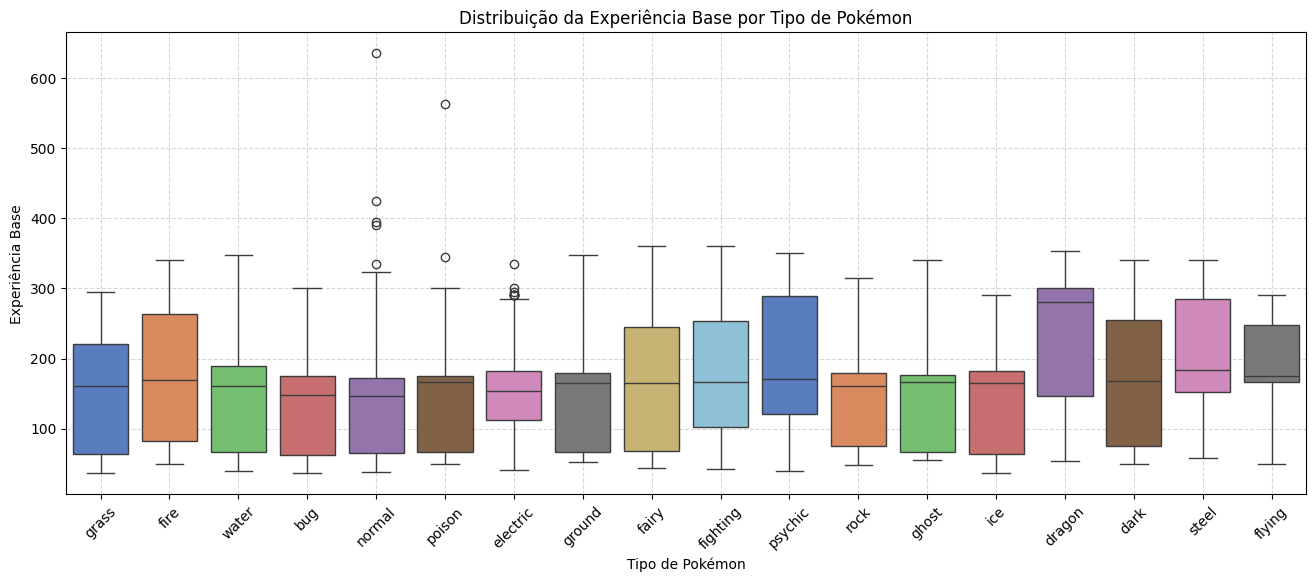

In [20]:
# Plotando o boxplot para visualizar a distribuição da experiência base por tipo de Pokémon
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_pokemons_tipos, x='nome_tipo', y='experiencia_base', palette='muted', hue='nome_tipo', dodge=False, legend=False)

# Melhorando a legibilidade do gráfico
plt.title('Distribuição da Experiência Base por Tipo de Pokémon')
plt.xlabel('Tipo de Pokémon')
plt.ylabel('Experiência Base')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend([], [], frameon=False)  # Removendo a legenda duplicada
plt.show()

O gráfico de boxplot mostra a distribuição da experiência base dos Pokémons por tipo. A linha horizontal dentro de cada caixa representa a mediana da experiência base para cada tipo de Pokémon. As caixas mostram a interquartil range (IQR), que é o intervalo entre o primeiro quartil (Q1) e o terceiro quartil (Q3), representando a dispersão central dos dados.

Algumas observações específicas:

- **Dragon**: O tipo `dragon` tem uma mediana alta, indicando que os Pokémons desse tipo, em média, possuem maiores experiências base.
- **Psychic e Steel**: Esses tipos de Pokémon também apresentam medianas relativamente altas.
- **Electric**: Esse tipo mostra uma menor dispersão na experiência base, com a maioria dos valores concentrados em torno da mediana.
- **Outliers**: Observa-se a presença de outliers em vários tipos, como `normal`, `poison`, e `electric`, indicando Pokémons com experiência base significativamente diferente do restante do grupo.
- **Dispersão**: Os tipos `normal` e `poison` têm uma maior amplitude (distância do mínimo ao máximo) geral, indicando uma grande variabilidade na experiência base entre os Pokémons desses tipos.

Em resumo, o gráfico de boxplot facilita a visualização da mediana, da dispersão dos dados e dos outliers para cada tipo de Pokémon, proporcionando uma análise mais detalhada e precisa da distribuição da experiência base por tipo.

#### 13.2. A altura e o peso dos Pokémons variam significativamente entre diferentes tipos

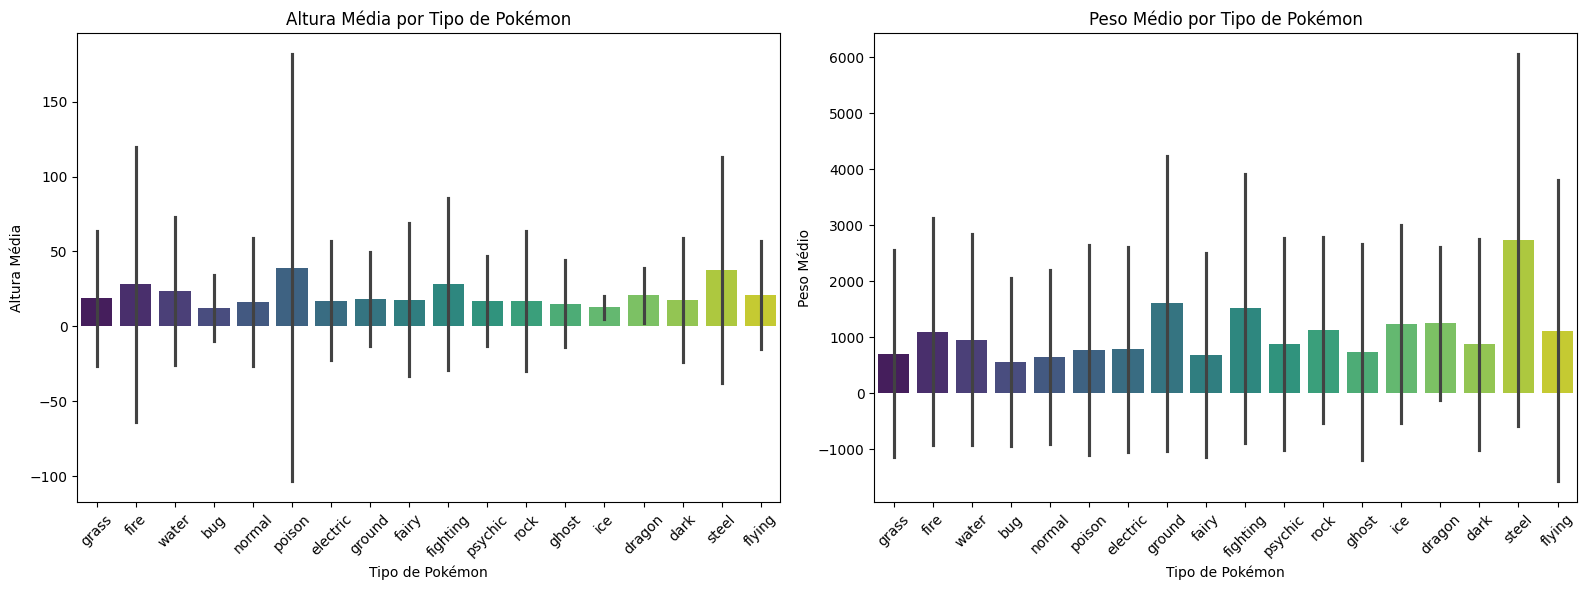

In [21]:
# Criar uma figura com duas subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de Altura Média por Tipo de Pokémon
sns.barplot(ax=axes[0], data=df_pokemons_tipos, x='nome_tipo', y='altura', errorbar='sd', hue='nome_tipo', palette='viridis', dodge=False)
axes[0].set_title('Altura Média por Tipo de Pokémon')
axes[0].set_xlabel('Tipo de Pokémon')
axes[0].set_ylabel('Altura Média')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend([],[], frameon=False)  # Removendo a legenda duplicada

# Gráfico de Peso Médio por Tipo de Pokémon
sns.barplot(ax=axes[1], data=df_pokemons_tipos, x='nome_tipo', y='peso', errorbar='sd', hue='nome_tipo', palette='viridis', dodge=False)
axes[1].set_title('Peso Médio por Tipo de Pokémon')
axes[1].set_xlabel('Tipo de Pokémon')
axes[1].set_ylabel('Peso Médio')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend([],[], frameon=False)  # Removendo a legenda duplicada

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar a figura com os gráficos
plt.show()

Estes gráficos de barras mostram a altura e o peso médios de Pokémons por tipo. A linha preta vertical em cada barra representa o desvio padrão, indicando a variabilidade dos dados.

Observações específicas:

- **Altura Média**:
  - O tipo `poison` apresenta uma alta variabilidade na altura, com alguns Pokémons muito altos e outros muito baixos.
  - Os tipos `fire` e `steel` também apresentam uma variabilidade significativa na altura.
  - Tipos como `dragon` apresenta menor variabilidade, indicando alturas mais uniformes entre os Pokémons desses tipos.

- **Peso Médio**:
  - O tipo `steel` apresenta a maior variabilidade no peso, com alguns Pokémons muito pesados e outros muito leves.
  - Os tipos `fighting` e `flying` também apresentam uma alta variabilidade no peso.
  - Tipos como `dragon`, `ground` e `ice` apresentam menor variabilidade, indicando pesos mais uniformes entre os Pokémons desses tipos.

Em resumo, a variabilidade na altura e no peso dos Pokémons varia significativamente entre os diferentes tipos. Os tipos `poison` e `steel` destacam-se pela alta variabilidade em altura e peso, respectivamente.

In [22]:
# Consulta SQL para trazer a média da altura e a média do peso por tipo de Pokémon
query_media_altura_peso_por_tipo = """
SELECT 
    t.nome AS tipo,
    AVG(p.altura) AS altura_media
FROM pokemons p
JOIN tipos t ON p.id_tipo_1 = t.id
GROUP BY t.nome
ORDER BY altura_media DESC
"""

# Executar a consulta
df_media_altura_peso = executar_consulta(query_media_altura_peso_por_tipo)

# Mostrar os resultados
print(df_media_altura_peso)

        tipo  altura_media
0     poison     39.196078
1      steel     37.612245
2   fighting     28.298246
3       fire     28.225000
4      water     23.757962
5     flying     21.230769
6     dragon     20.865385
7      grass     18.635593
8     ground     18.416667
9      fairy     17.878788
10      dark     17.644068
11  electric     17.093750
12      rock     16.827160
13   psychic     16.662651
14    normal     16.492754
15     ghost     15.117647
16       ice     12.813953
17       bug     12.322581


In [23]:
# Consulta SQL para trazer a média da altura e a média do peso por tipo de Pokémon
query_media_altura_peso_por_tipo = """
SELECT 
    t.nome AS tipo,
    AVG(p.peso) AS peso_medio
FROM pokemons p
JOIN tipos t ON p.id_tipo_1 = t.id
GROUP BY t.nome
ORDER BY peso_medio DESC
"""

# Executar a consulta
df_media_altura_peso = executar_consulta(query_media_altura_peso_por_tipo)

# Mostrar os resultados
print(df_media_altura_peso)

        tipo   peso_medio
0      steel  2727.122449
1     ground  1604.125000
2   fighting  1513.157895
3     dragon  1246.442308
4        ice  1229.767442
5       rock  1119.654321
6     flying  1112.076923
7       fire  1091.912500
8      water   950.280255
9    psychic   878.638554
10      dark   872.542373
11  electric   778.322917
12    poison   767.529412
13     ghost   735.215686
14     grass   702.500000
15     fairy   677.666667
16    normal   641.659420
17       bug   551.000000


#### 13.3. Alguns tipos são mais comuns que outros entre os Pokémons

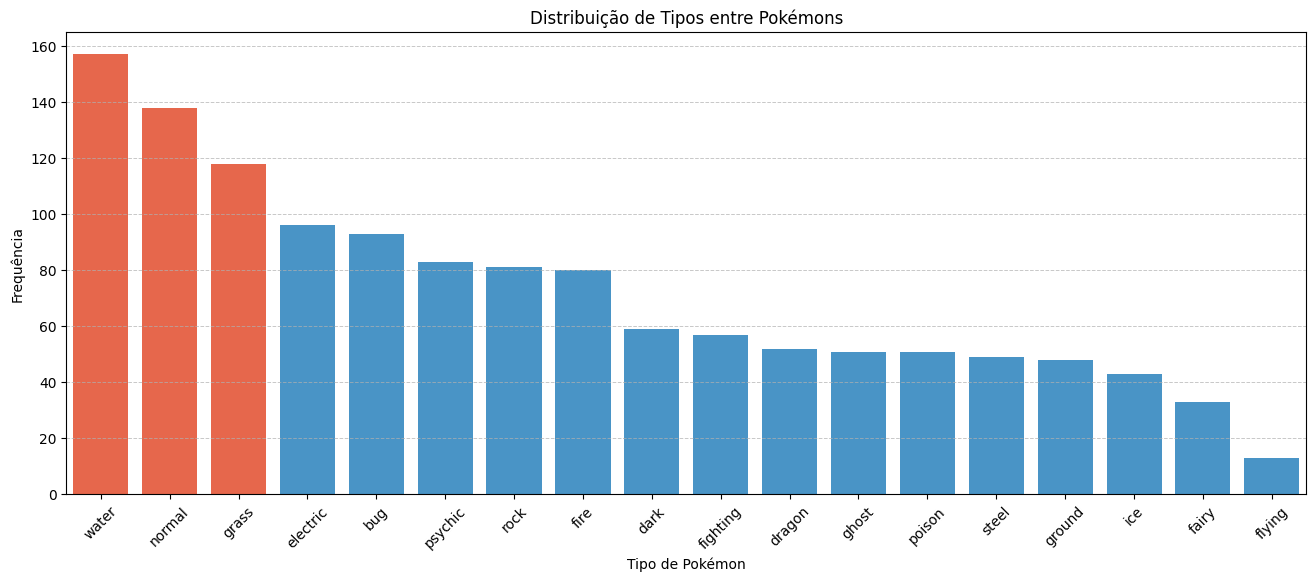

In [24]:
# Contar a frequência de cada tipo de Pokémon e ordenar de forma decrescente
tipo_counts = df_pokemons_tipos['nome_tipo'].value_counts().reset_index()
tipo_counts.columns = ['nome_tipo', 'frequencia']
tipo_counts = tipo_counts.sort_values(by='frequencia', ascending=False)

# Reorganizar o DataFrame original para refletir a nova ordem
df_pokemons_tipos['nome_tipo'] = pd.Categorical(df_pokemons_tipos['nome_tipo'], categories=tipo_counts['nome_tipo'], ordered=True)

# Criar uma paleta de cores com destaque para os top 3 tipos
top_3_types = tipo_counts['nome_tipo'][:3].values
palette = ['#FF5733' if x in top_3_types else '#3498db' for x in df_pokemons_tipos['nome_tipo'].cat.categories]

# Plotar o gráfico
plt.figure(figsize=(16, 6))
sns.countplot(data=df_pokemons_tipos, x='nome_tipo', order=tipo_counts['nome_tipo'], hue='nome_tipo', palette=palette, dodge=False)
plt.title('Distribuição de Tipos entre Pokémons')
plt.xlabel('Tipo de Pokémon')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)  # Removendo a legenda duplicada

# Adicionar grade discreta
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Mostrar o gráfico
plt.show()

O gráfico de barras mostra a frequência de cada tipo de Pokémon na base de dados. É visível que os tipos `water`, `normal` e `grass` são os mais comuns, enquanto `fairy` e `flying` são os menos frequentes.

Observações específicas:

- **Water**: Com aproximadamente 160 Pokémons, o tipo `water` é o mais frequente na base de dados, indicando uma ampla diversidade de Pokémons deste tipo.
- **Normal**: O segundo tipo mais comum, com cerca de 140 Pokémons. A alta frequência sugere que Pokémons `normal` são amplamente distribuídos e variados.
- **Grass**: O terceiro tipo mais comum, com aproximadamente 120 Pokémons. Isso destaca a prevalência de Pokémons `grass` na base de dados.
- **Fairy e Flying**: Com menos de 40 Pokémons cada, esses são os tipos menos frequentes na base de dados, indicando uma menor diversidade e quantidade de Pokémons desses tipos.

Conclusões:

- A alta frequência dos tipos `water`, `normal` e `grass` pode refletir uma maior importância desses tipos no ecossistema Pokémon ou na mecânica do jogo.
- A baixa frequência dos tipos `fairy` e `flying` pode indicar que esses tipos são mais raros ou especializados, possivelmente com habilidades e características únicas.

Em resumo, a análise da frequência dos tipos de Pokémons na base de dados revela tendências importantes sobre a distribuição e diversidade dos diferentes tipos.

#### 13.4. Pokémons com experiência base muito alta são raros

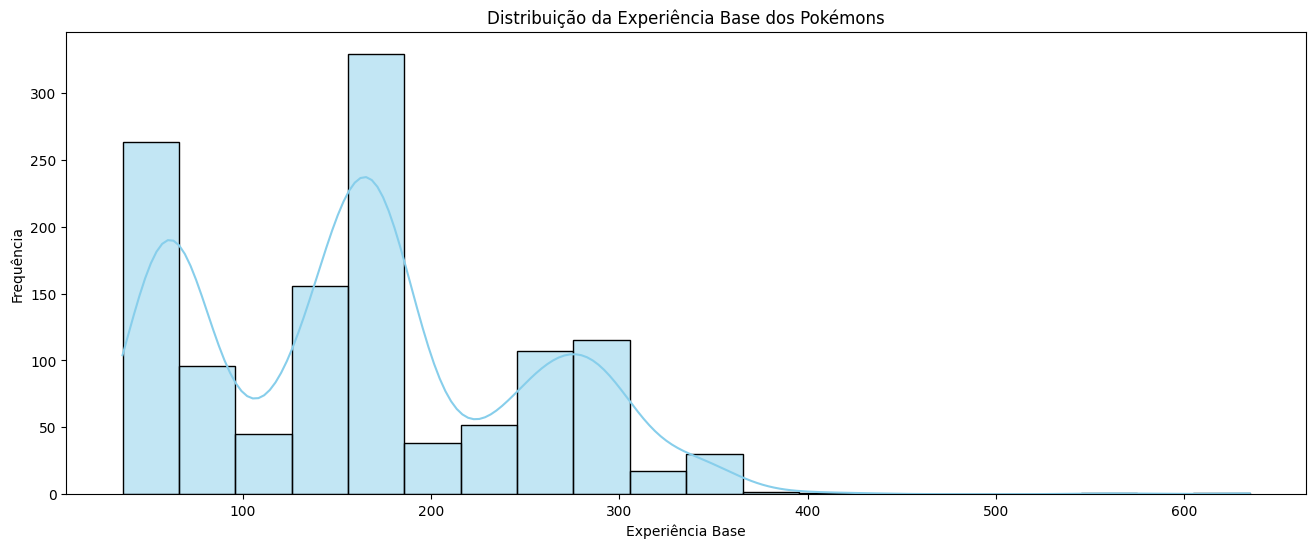

In [25]:
# Plotar o histograma com KDE
plt.figure(figsize=(16, 6))
sns.histplot(data=df_pokemons, x='experiencia_base', bins=20, kde=True, color='skyblue')
plt.title('Distribuição da Experiência Base dos Pokémons')
plt.xlabel('Experiência Base')
plt.ylabel('Frequência')
plt.show()

O gráfico de distribuição mostra a frequência da experiência base dos Pokémons na base de dados. É possível observar que a maioria dos Pokémons tem uma experiência base entre 50 e 250, enquanto valores muito altos de experiência base são raros.

Observações específicas:

- **Pico em Experiência Base Baixa**: Há uma concentração de Pokémons entre 50 e 100 de experiência base, indicando que muitos Pokémons possuem uma experiência base relativamente baixa.
- **Segundo Pico entre 150 e 200**: Outro pico significativo é observado entre 150 e 200 de experiência base, mostrando uma segunda concentração de Pokémons nessa faixa.
- **Experiência Base Muito Alta é Rara**: Poucos Pokémons têm uma experiência base acima de 350, e quase nenhum acima de 400, indicando que valores muito altos de experiência base são raros.

Conclusões:

- A distribuição da experiência base dos Pokémons é bimodal, com dois picos principais nas faixas de 50-100 e 150-200.
- Pokémons com experiência base muito alta (acima de 350) são raros, o que pode indicar que esses Pokémons são mais poderosos ou difíceis de encontrar.
- A maioria dos Pokémons na base de dados tem uma experiência base moderada, refletindo uma distribuição equilibrada com alguns outliers de alta experiência.

Em resumo, a análise da distribuição da experiência base dos Pokémons revela que Pokémons com valores muito altos de experiência base são raros, enquanto a maioria tem valores entre 50 e 250.

#### 13.5. Há correlação forte ou muito forte entre o peso e altura do pokémon e sua experiência base

In [26]:
# Selecionar as colunas de interesse
df_correlacao = df_pokemons[['altura', 'peso', 'experiencia_base']]

# Calcular a matriz de correlação
matriz_correlacao = df_correlacao.corr()

# Exibir a matriz de correlação
print(matriz_correlacao)

                    altura      peso  experiencia_base
altura            1.000000  0.674194          0.244535
peso              0.674194  1.000000          0.349275
experiencia_base  0.244535  0.349275          1.000000


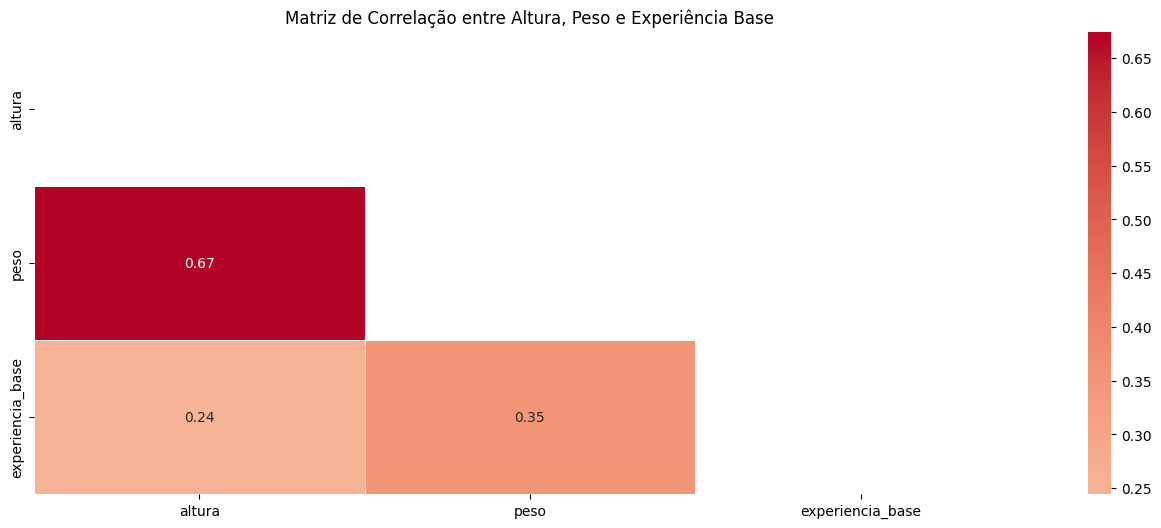

In [27]:
# Criando uma máscara para ocultar os valores repetidos acima da diagonal principal
mask = np.triu(np.ones_like(matriz_correlacao, dtype=bool))

# Visualizar a matriz de correlação com um heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', center=0, mask=mask, linewidths=.5)
plt.title('Matriz de Correlação entre Altura, Peso e Experiência Base')
plt.show()

A matriz de correlação mostra a relação entre altura, peso e experiência base dos Pokémons. A correlação varia de -1 a 1, onde valores próximos de 1 indicam uma forte correlação positiva, valores próximos de -1 indicam uma forte correlação negativa, e valores próximos de 0 indicam pouca ou nenhuma correlação.

Classificação das correlações:

- 0.00 a 0.19: Correlação bem fraca
- 0.20 a 0.39: Correlação fraca
- 0.40 a 0.69: Correlação moderada
- 0.70 a 0.89: Correlação forte
- 0.90 a 1.00: Correlação muito forte

Observações específicas:

- **Altura e Peso**: Há uma correlação moderada (0.67) entre a altura e o peso dos Pokémons. Isso indica que Pokémons mais altos tendem a ser mais pesados.
- **Peso e Experiência Base**: Existe uma correlação fraca (0.35) entre o peso e a experiência base dos Pokémons, sugerindo que Pokémons mais pesados tendem a ter uma experiência base maior, mas não de forma tão consistente.
- **Altura e Experiência Base**: A correlação entre altura e experiência base é bem fraca (0.24), indicando que a altura dos Pokémons tem um impacto muito menor na sua experiência base.

Conclusões:

- A correlação moderada entre altura e peso é esperada, pois normalmente Pokémons mais altos também são mais pesados.
- A correlação fraca entre peso e experiência base sugere que o peso pode ser um fator que contribui para a experiência base dos Pokémons, mas não é o único fator.
- A correlação bem fraca entre altura e experiência base indica que a altura tem um impacto muito pequeno na determinação da experiência base dos Pokémons.

Em resumo, a análise da matriz de correlação revela que, embora existam correlações entre altura, peso e experiência base dos Pokémons, a força dessas correlações varia, com a relação mais forte observada entre altura e peso.